In [104]:
import numpy as np
import tensorflow as tf
from io import StringIO

In [105]:
# Package imports
# Matplotlib 
import matplotlib
import matplotlib.pyplot as plt
# SciKitLearn is a machine learning utilities library
import sklearn
# The sklearn dataset module helps generating datasets
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from tensorflow.python.framework import ops

%matplotlib inline

In [106]:
x = np.genfromtxt('poker-hand-training-true.data', delimiter=',',dtype=None)
y = np.genfromtxt('poker-hand-testing.data', delimiter=',',dtype=None)

In [107]:
print(x)

[[ 1 10  1 ...,  1  1  9]
 [ 2 11  2 ...,  2  1  9]
 [ 3 12  3 ...,  3  1  9]
 ..., 
 [ 2  1  2 ...,  4 13  1]
 [ 2 12  4 ...,  4  9  1]
 [ 1  7  3 ...,  3  7  1]]


In [108]:
print(x.shape)

(25010, 11)


In [109]:
y_train = x[0:,10]

In [110]:
print(y_train)

[9 9 9 ..., 1 1 1]


In [111]:
x_train = x[0:,0:10]

In [112]:
print(x_train)
print(x_train.shape)
print(x_train.reshape(x_train.shape[0], -1).T)

[[ 1 10  1 ..., 12  1  1]
 [ 2 11  2 ..., 12  2  1]
 [ 3 12  3 ..., 10  3  1]
 ..., 
 [ 2  1  2 ...,  1  4 13]
 [ 2 12  4 ..., 12  4  9]
 [ 1  7  3 ...,  8  3  7]]
(25010, 10)
[[ 1  2  3 ...,  2  2  1]
 [10 11 12 ...,  1 12  7]
 [ 1  2  3 ...,  2  4  3]
 ..., 
 [12 12 10 ...,  1 12  8]
 [ 1  2  3 ...,  4  4  3]
 [ 1  1  1 ..., 13  9  7]]


In [113]:
np.random.seed(0)

In [114]:
print(x_train.T)

[[ 1  2  3 ...,  2  2  1]
 [10 11 12 ...,  1 12  7]
 [ 1  2  3 ...,  2  4  3]
 ..., 
 [12 12 10 ...,  1 12  8]
 [ 1  2  3 ...,  4  4  3]
 [ 1  1  1 ..., 13  9  7]]


In [115]:
print (y[0])
y_test = y[0:,10]
x_test = y[0:,0:10]

[ 1  1  1 13  2  4  2  3  1 12  0]


In [116]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [117]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32, shape=[n_y,None], name='Y')
    
    return X, Y

In [118]:
y_train_new = convert_to_one_hot(y_train,10)
y_test_new = convert_to_one_hot(y_test,10)
print(y_train_new.shape)
print(y_test_new.shape)

(10, 25010)
(10, 1000000)


In [119]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [50,10], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [50, 1], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [25,50], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [25, 1], initializer=tf.contrib.layers.xavier_initializer())
    W3 = tf.get_variable("W3", [10,25], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [10, 1], initializer=tf.contrib.layers.xavier_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  }
    
    return parameters

In [120]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    #A1 = tf.nn.dropout(A1, keep_prob = 0.99) #adding drop out for first layer with 0.98 probability.
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    #A2 = tf.nn.dropout(A2, keep_prob = 0.91)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [121]:
def compute_cost(Z3,Y, parameters):
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    #using L2 regularization 
    Lambda=0.025
    
    cost_normal = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    l2_cost = Lambda*(tf.nn.l2_loss(parameters["W1"]) + tf.nn.l2_loss(parameters["W2"]) + tf.nn.l2_loss(parameters["W3"]))
    
    cost = tf.add(cost_normal, l2_cost, name='cost')
    
    return cost

In [123]:
def model(X_train, Y_train,X_test, Y_test, learning_rate = 0.00003,
          num_epochs = 2500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    #print(m)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y , parameters)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_epochs):  
            sess.run([optimizer,cost], feed_dict={X: X_train, Y: Y_train}) # Take a gradient descent step using our inputs and labels

            # That's all! The rest of the cell just outputs debug messages. 
            # Display logs per epoch step
            if (i) % 100 == 0:
                cc = sess.run(cost, feed_dict={X: X_train, Y:Y_train})
                print ("Training step:", '%04d' % (i), "cost=", "{:.9f}".format(cc) )#, \"W=", sess.run(W), "b=", sess.run(b)
            #if print_cost == True and num_epochs % 100 == 0:
             #   print ("Cost after epoch %i: %f" % (num_epochs, cost))
            if print_cost == True and num_epochs % 5 == 0:
                costs.append(cc)
                 
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
       

Training step: 0000 cost= 4.985488892
Training step: 0100 cost= 3.991859198
Training step: 0200 cost= 3.260223150
Training step: 0300 cost= 2.771762609
Training step: 0400 cost= 2.471656322
Training step: 0500 cost= 2.294132710
Training step: 0600 cost= 2.184741020
Training step: 0700 cost= 2.110076904
Training step: 0800 cost= 2.053000212
Training step: 0900 cost= 2.005035639
Training step: 1000 cost= 1.963050365
Training step: 1100 cost= 1.925229073
Training step: 1200 cost= 1.890754938
Training step: 1300 cost= 1.859027386
Training step: 1400 cost= 1.829735756
Training step: 1500 cost= 1.802467346
Training step: 1600 cost= 1.776953459
Training step: 1700 cost= 1.753005743
Training step: 1800 cost= 1.730508089
Training step: 1900 cost= 1.709544182
Training step: 2000 cost= 1.690065384
Training step: 2100 cost= 1.672005892
Training step: 2200 cost= 1.655185103
Training step: 2300 cost= 1.639514685
Training step: 2400 cost= 1.624933243


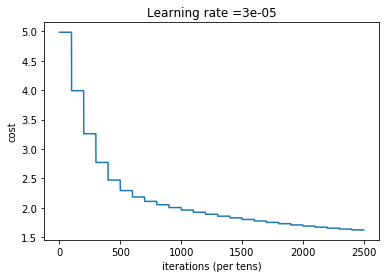

Parameters have been trained!
Train Accuracy: 0.491164
Test Accuracy: 0.491691


In [125]:
parameters = model(x_train.T, y_train_new, x_test.T, y_test_new)